In [47]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import lxml
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from ripser import ripser
from persim import plot_diagrams

In [3]:
sp500 = list(pd.read_csv('sp500_companies.csv')['Symbol'])

In [4]:
for tick in ['ANSS', 'DFS', 'JNPR', 'WBA', 'HES', 'PARA']:
    sp500.remove(tick)

In [83]:
# prices = yf.download(
#     sp500,
#     start="2025-01-01",
#     end="2025-12-31"
# )["Close"]
# prices = prices.ffill()
# returns = prices.pct_change().dropna()
# returns.head()
# # Correlation matrix
# corr = returns.corr().values

# # Convert correlation to distance for weights
# dist = np.sqrt(2 * (1 - corr))
# np.fill_diagonal(dist, 0)
# G = nx.Graph()

# # Add nodes
# for i, ticker in enumerate(sp500):
#     G.add_node(i, label=ticker)

# # Add edges with correlation weights
# for i in range(len(sp500)):
#     for j in range(i+1, len(sp500)):
#         # Higher correlation → stronger connection → smaller distance → weight = corr
#         G.add_edge(i, j, weight=corr[i, j])

In [85]:
import yfinance as yf
import numpy as np
import pandas as pd
import networkx as nx

# Stock tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "JPM", "XOM", "CVX"]

# Download data
data = yf.download(tickers, start="2022-01-01", end="2024-01-01")["Close"]

# Drop missing rows
data = data.dropna(how='any')

# Daily log returns
returns = np.log(data / data.shift(1)).dropna(how='any')

# Correlation matrix
corr = returns.corr().values

# Build graph
G = nx.Graph()
for i, ticker in enumerate(tickers):
    G.add_node(i, label=ticker)

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        G.add_edge(i, j, weight=corr[i, j])


[*********************100%***********************]  8 of 8 completed


In [86]:
# Node-level features
node_features = []

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    subgraph = G.subgraph(neighbors + [node])

    # Graph features
    degree = G.degree(node)
    strength = sum([G[node][nbr]['weight'] for nbr in G.neighbors(node)])
    clustering = nx.clustering(G, node, weight='weight')  # local clustering coefficient
    # Loop participation (approximate Betti-1)
    loops = sum(1 for cycle in nx.cycle_basis(subgraph) if node in cycle)

    node_features.append([degree, strength, clustering, loops])

node_features = np.array(node_features)
print("Node feature matrix shape:", node_features.shape)


Node feature matrix shape: (8, 4)


In [87]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(node_features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Combine with tickers
df_clusters = pd.DataFrame({
    "Ticker": tickers,
    "Degree": node_features[:,0],
    "Strength": node_features[:,1],
    "ClusteringCoeff": node_features[:,2],
    "LoopCount": node_features[:,3],
    "Cluster": labels
})

print(df_clusters)


  Ticker  Degree  Strength  ClusteringCoeff  LoopCount  Cluster
0   AAPL     7.0  3.571071         0.496604        6.0        1
1   MSFT     7.0  3.293448         0.467136        6.0        1
2  GOOGL     7.0  2.058253         0.318759        6.0        0
3   AMZN     7.0  3.431919         0.473282        6.0        1
4   META     7.0  2.608215         0.424412        6.0        2
5    JPM     7.0  2.893539         0.423747        6.0        2
6    XOM     7.0  3.403211         0.469606        6.0        1
7    CVX     7.0  1.823675         0.283140       21.0        0


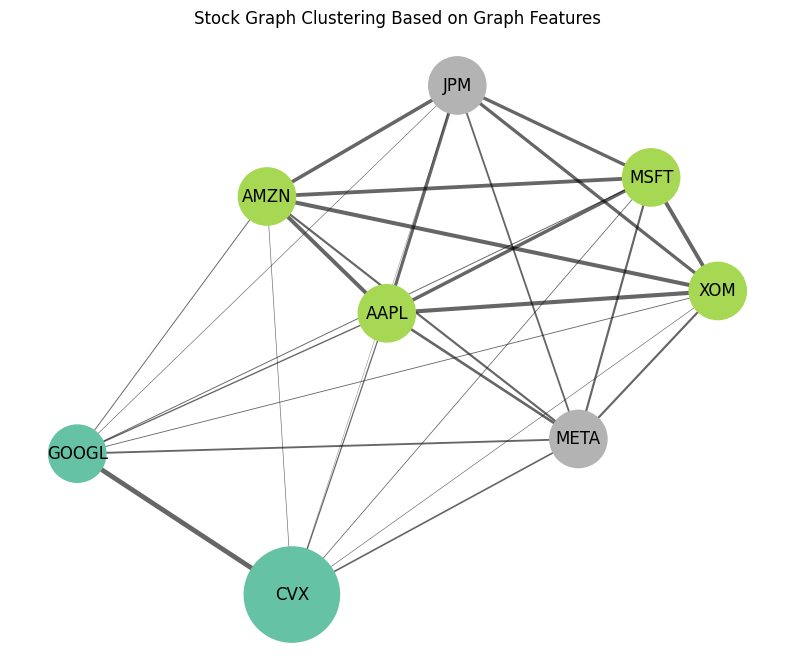

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)

node_sizes = 500 + 200 * node_features[:,3]  # loop count as size
node_colors = labels  # cluster color

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set2)
nx.draw_networkx_edges(G, pos, width=[4*G[u][v]['weight'] for u,v in G.edges()], alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i: tickers[i] for i in range(len(tickers))})

plt.title("Stock Graph Clustering Based on Graph Features")
plt.axis('off')
plt.show()


In [89]:
# Node-level features: degree, strength, clustering, loop participation
node_features = []

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    subgraph = G.subgraph(neighbors + [node])

    degree = G.degree(node)
    strength = sum([G[node][nbr]['weight'] for nbr in G.neighbors(node)])
    clustering = nx.clustering(G, node, weight='weight')
    loops = sum(1 for cycle in nx.cycle_basis(subgraph) if node in cycle)

    node_features.append([degree, strength, clustering, loops])

node_features = np.array(node_features)


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(node_features)

# Create similarity matrix using RBF kernel
similarity_matrix = rbf_kernel(X_scaled, gamma=0.5)  # gamma controls kernel width

# Spectral clustering
sc = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)
labels = sc.fit_predict(similarity_matrix)

# Combine results with tickers
df_clusters = pd.DataFrame({
    "Ticker": tickers,
    "Degree": node_features[:,0],
    "Strength": node_features[:,1],
    "ClusteringCoeff": node_features[:,2],
    "LoopCount": node_features[:,3],
    "Cluster": labels
})

print(df_clusters)


  Ticker  Degree  Strength  ClusteringCoeff  LoopCount  Cluster
0   AAPL     7.0  3.571071         0.496604        6.0        0
1   MSFT     7.0  3.293448         0.467136        6.0        0
2  GOOGL     7.0  2.058253         0.318759        6.0        2
3   AMZN     7.0  3.431919         0.473282        6.0        0
4   META     7.0  2.608215         0.424412        6.0        0
5    JPM     7.0  2.893539         0.423747        6.0        0
6    XOM     7.0  3.403211         0.469606        6.0        0
7    CVX     7.0  1.823675         0.283140       21.0        1


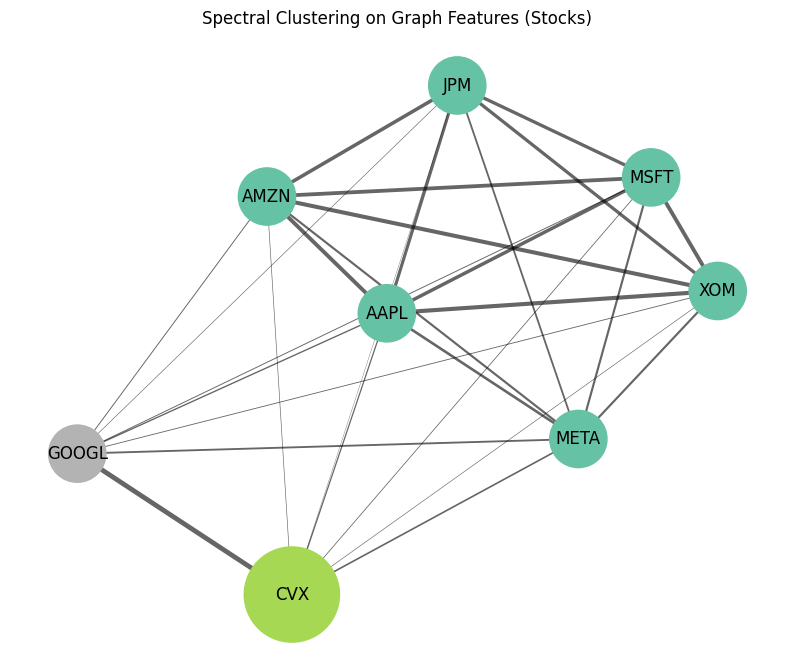

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)

node_sizes = 500 + 200 * node_features[:,3]  # node size = loop count
node_colors = labels  # cluster colors

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set2)
nx.draw_networkx_edges(G, pos, width=[4*G[u][v]['weight'] for u,v in G.edges()], alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i: tickers[i] for i in range(len(tickers))})

plt.title("Spectral Clustering on Graph Features (Stocks)")
plt.axis('off')
plt.show()


In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(node_features)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.99093829 0.00905504]


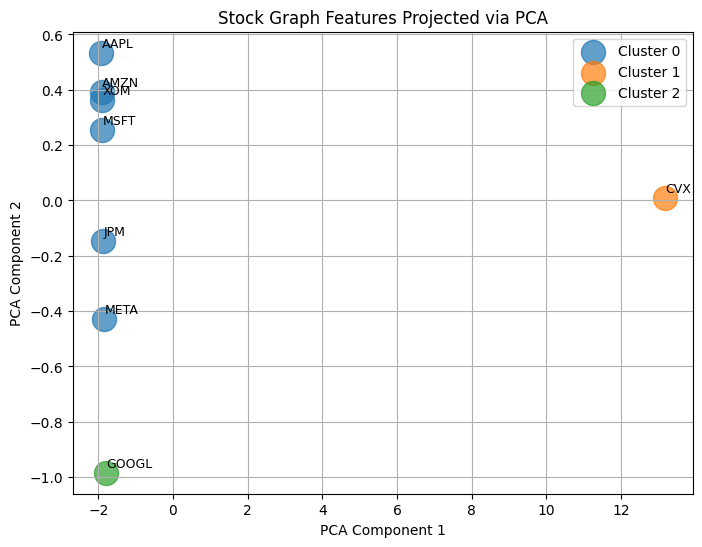

In [93]:
plt.figure(figsize=(8,6))

# Scatter plot, colored by cluster
for cluster_id in np.unique(labels):
    idx = labels == cluster_id
    plt.scatter(
        X_pca[idx,0],
        X_pca[idx,1],
        label=f'Cluster {cluster_id}',
        s=300,
        alpha=0.7
    )

# Annotate with tickers
for i, ticker in enumerate(tickers):
    plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, ticker, fontsize=9)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Stock Graph Features Projected via PCA")
plt.legend()
plt.grid(True)
plt.show()
